# 2: Initial Tensorflow Exploration

# Imports

In [1]:
# ! pip install seaborn
# ! pip install librosa

In [2]:
# General imports
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from math import floor

In [3]:
# import librosa for audio processing
import librosa

# for displaying playback
import IPython.display as ipd

# STFT Imports
from scipy.signal import stft
from scipy.signal import istft


In [4]:
! python --version

Python 3.7.6


In [5]:
# not available for python 3.9.2 :(
# pip install -q tensorflow-io

In [6]:
# not available for python 3.9.2
# import tensorflow_io as tfio

In [7]:
# import tensorflow
import tensorflow as tf

# check version
tf.version.VERSION

'2.4.1'

In [8]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

keras = tf.keras

# for displaying playback, et al
from IPython import display

# Seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [9]:
# System filepath setup
import sys

# add data, src and img folders to filepath
# add data folders to path
sys.path.insert(1, '../data')
sys.path.insert(1, '../src')
sys.path.insert(1, '../img')

# check local filepath

Reference:
- [How to train a Keras model on TFRecord files](https://keras.io/examples/keras_recipes/tfrecord/)

## Import Comprehnsive DataFrame

The `comprehensive_df` contains:
- tp and fp listings (time in/out, frequency min/max) for 24 species for each audio file


In [10]:
comprehensive_df = pd.read_pickle("../data/pickle_files/comprehensive_df.pkl")

In [11]:
print(comprehensive_df.shape)
comprehensive_df.head()

(8997, 32)


,recording_id,label_type,species_id,songtype_id,t_min,f_min,t_max,f_max,tp_0,tp_1,...,tp_14,tp_15,tp_16,tp_17,tp_18,tp_19,tp_20,tp_21,tp_22,tp_23
0,003bec244,tp,14,1,44.5440,2531.250,45.1307,5531.25,0,0,...,1,0,0,0,0,0,0,0,0,0
1,006ab765f,tp,23,1,39.9615,7235.160,46.0452,11283.40,0,0,...,0,0,0,0,0,0,0,0,0,1
2,007f87ba2,tp,12,1,39.1360,562.500,42.2720,3281.25,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0099c367b,tp,17,4,51.4206,1464.260,55.1996,4565.04,0,0,...,0,0,0,1,0,0,0,0,0,0
4,009b760e6,tp,10,1,50.0854,947.461,52.5293,10852.70,0,0,...,0,0,0,0,0,0,0,0,0,0


# Add one-hot column for fp data

Normally, all zeros in other columns would indicate another category (no calls detected in our case). Our model seems to prefer this to have its own one hot encoded category.

In [12]:
comprehensive_df['no_calls'] = 0

In [13]:
comprehensive_df.columns

Index(['recording_id', 'label_type', 'species_id', 'songtype_id', 't_min',
       'f_min', 't_max', 'f_max', 'tp_0', 'tp_1', 'tp_2', 'tp_3', 'tp_4',
       'tp_5', 'tp_6', 'tp_7', 'tp_8', 'tp_9', 'tp_10', 'tp_11', 'tp_12',
       'tp_13', 'tp_14', 'tp_15', 'tp_16', 'tp_17', 'tp_18', 'tp_19', 'tp_20',
       'tp_21', 'tp_22', 'tp_23', 'no_calls'],
      dtype='object')

In [14]:
# boolean mask where label_type is 'fp'

fp_bool = comprehensive_df['label_type'] == 'fp'
comprehensive_df.loc[fp_bool, 'no_calls'] = 1

comprehensive_df.tail()

,recording_id,label_type,species_id,songtype_id,t_min,f_min,t_max,f_max,tp_0,tp_1,...,tp_15,tp_16,tp_17,tp_18,tp_19,tp_20,tp_21,tp_22,tp_23,no_calls
7776,ffd88cd84,fp,14,1,3.2000,2531.25,3.7867,5531.25,0,0,...,0,0,0,0,0,0,0,0,0,1
7777,ffebe7313,fp,1,1,35.2000,3843.75,36.0960,5625.00,0,0,...,0,0,0,0,0,0,0,0,0,1
7778,fff163132,fp,17,4,22.5547,1312.50,25.0880,7406.25,0,0,...,0,0,0,0,0,0,0,0,0,1
7779,fff163132,fp,14,1,37.0827,2531.25,37.6693,5531.25,0,0,...,0,0,0,0,0,0,0,0,0,1
7780,fffb79246,fp,6,1,8.3573,562.50,10.5013,4406.25,0,0,...,0,0,0,0,0,0,0,0,0,1


# Preparing Data: Selecting Species with calls shorter than 1 second

Species 1, 3, 14, 18 all have maximum tp call lengths of less then one second.

This will enable a consistent, 1 second window for the shortest sample sounds, while still enabling a multiclassification test.

In [15]:
sub_1_bool = (comprehensive_df['species_id'] == 1) | \
             (comprehensive_df['species_id'] == 3) | \
             (comprehensive_df['species_id'] == 14) | \
             (comprehensive_df['species_id'] == 18) 

          

In [16]:
sub_1_df = comprehensive_df[sub_1_bool]

In [17]:
sub_1_df

,recording_id,label_type,species_id,songtype_id,t_min,f_min,t_max,f_max,tp_0,tp_1,...,tp_15,tp_16,tp_17,tp_18,tp_19,tp_20,tp_21,tp_22,tp_23,no_calls
0,003bec244,tp,14,1,44.5440,2531.25,45.1307,5531.25,0,0,...,0,0,0,0,0,0,0,0,0,0
7,011f25080,tp,18,1,5.6853,3187.50,6.3787,5062.50,0,0,...,0,0,0,1,0,0,0,0,0,0
9,0151b7d20,tp,1,1,46.0320,3843.75,46.9280,5625.00,0,1,...,0,0,0,0,0,0,0,0,0,0
22,043356ff8,tp,18,1,0.1227,3187.50,0.8160,5062.50,0,0,...,0,0,0,1,0,0,0,0,0,0
27,050d0ca85,tp,3,1,49.9200,1031.25,50.6613,2812.50,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7764,ff858780b,fp,18,1,44.1760,3187.50,44.8693,5062.50,0,0,...,0,0,0,0,0,0,0,0,0,1
7773,ffd88cd84,fp,14,1,2.1547,2531.25,2.7413,5531.25,0,0,...,0,0,0,0,0,0,0,0,0,1
7776,ffd88cd84,fp,14,1,3.2000,2531.25,3.7867,5531.25,0,0,...,0,0,0,0,0,0,0,0,0,1
7777,ffebe7313,fp,1,1,35.2000,3843.75,36.0960,5625.00,0,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
sub_1_df.iloc[0]

recording_id    003bec244
label_type             tp
species_id             14
songtype_id             1
t_min              44.544
f_min             2531.25
t_max             45.1307
f_max             5531.25
tp_0                    0
tp_1                    0
tp_2                    0
tp_3                    0
tp_4                    0
tp_5                    0
tp_6                    0
tp_7                    0
tp_8                    0
tp_9                    0
tp_10                   0
tp_11                   0
tp_12                   0
tp_13                   0
tp_14                   1
tp_15                   0
tp_16                   0
tp_17                   0
tp_18                   0
tp_19                   0
tp_20                   0
tp_21                   0
tp_22                   0
tp_23                   0
no_calls                0
Name: 0, dtype: object

In [19]:
# relative filepath to local flac audio files
! ls ../data/rfcx-species-audio-detection/train

00204008d.flac 32326a03d.flac 657339fdd.flac 9996f3de8.flac ce05b264d.flac
003b04435.flac 32464c219.flac 65971c0e7.flac 999bac2e2.flac ce0c22f8a.flac
003bec244.flac 3267e79e6.flac 65bcc9ad4.flac 99a3e9c18.flac ce1787eaa.flac
005f1f9a5.flac 326992b55.flac 65daa4d4d.flac 99aa327b4.flac ce332f2fa.flac
006ab765f.flac 3292bbae4.flac 65f32be6d.flac 99ad8ec2e.flac ce4002d4e.flac
0072f0839.flac 3296a3827.flac 660604c58.flac 99b8ad978.flac ce46ce19d.flac
0079ff47b.flac 32af58c85.flac 6606e8d7e.flac 99dac3985.flac ce4a422fa.flac
007f87ba2.flac 32c0ebf77.flac 6645f0d5d.flac 99ece8c7f.flac ce5b205f3.flac
00834f88e.flac 32cf84e6f.flac 664a8e8e5.flac 99efe9a99.flac ce66ba21f.flac
008c9c381.flac 32e42c4fb.flac 664ed0511.flac 99f72cf18.flac ce7273ce3.flac
0099c367b.flac 32ea5e03e.flac 6666e213d.flac 9a18a1177.flac ce7f36db6.flac
009aa1c8f.flac 32f8c551e.flac 666dd7d48.flac 9a33fd3e2.flac ce82507b3.flac
009b760e6.flac 3346f84ee.flac 667b7363f.flac 9a390abd3.flac ce8270c7b.flac
009fbc7b4.flac 338107119.

## Function: Get Filepath

In [20]:
def get_filepath(given_recording_id, local_filepath='../data/rfcx-species-audio-detection/train/', type='flac'):
    return f'{local_filepath}{str(given_recording_id)}.{type}'

## Function: Get Audio 1d Numpy Array

In [21]:
def get_audio_np(index, sr=48000, duration=1):
    
    r_id = index['recording_id']
    
    f_path = get_filepath(r_id)
    
    t_min_floor = floor(index['t_min'])
    
    audio_np_arr = librosa.load(path=f_path,
                                sr=sr,
                                offset=test_offset,
                                duration=duration)[0]
    return audio_np_arr
    

In [22]:
test_rec_id = sub_1_df.iloc[0]['recording_id']
test_path = get_filepath(test_rec_id)

print(type(test_path), test_path)

<class 'str'> ../data/rfcx-species-audio-detection/train/003bec244.flac


In [23]:
test_offset = floor(sub_1_df.iloc[0]['t_min'])


# typically load generates a tuple with the 1d np array and the sample rate (sr)
# we only need the np array
one_sec = librosa.load(path=test_path,
                      sr=48000,
                      offset=test_offset,
                      duration=1)[0]

In [24]:
print(type(one_sec))
print(one_sec.shape)
ipd.Audio(one_sec, rate=48000)

<class 'numpy.ndarray'>
(48000,)


# CHECK HERE!!!
## Create audio_np column

In [25]:
sub_1_df.insert(loc=1, column='audio_np_1d', value=sub_1_df.apply(lambda x: get_audio_np(x), axis='columns'))

In [26]:
# Check to see if these are different audio files....

print(sub_1_df['audio_np_1d'])

0       [-0.009979248, 0.0039367676, 0.003112793, -0.0...
7       [0.0070495605, -0.0012512207, -0.014587402, -0...
9       [0.007232666, 0.016235352, 0.027526855, 0.0141...
22      [-0.012237549, -0.0040893555, 0.006500244, 0.0...
27      [0.00091552734, 0.0030822754, 0.005859375, 0.0...
                              ...                        
7764    [0.0211792, 0.0052490234, -0.010955811, -0.015...
7773    [-0.019165039, -0.016540527, -0.013946533, 0.0...
7776    [-0.019165039, -0.016540527, -0.013946533, 0.0...
7777    [-0.009399414, -0.008331299, -0.01373291, -0.0...
7779    [-0.035888672, -0.076934814, -0.04425049, -0.0...
Name: audio_np_1d, Length: 1398, dtype: object


In [27]:
sub_1_df['audio_np_1d'].shape[0]

1398

In [28]:
# %%time

# # there is probably a faster method to do this...
# # the audio created here ends up being a little over 23 minutes...

# # long_audio = np.append(sub_1_df['audio_np_1d'].iloc[0], sub_1_df['audio_np_1d'].iloc[1])

# for i in range(sub_1_df['audio_np_1d'].shape[0]):
    
#     if i == 0:
#         long_audio = sub_1_df['audio_np_1d'].iloc[i]
#     else:
#         long_audio = np.append(long_audio, sub_1_df['audio_np_1d'].iloc[i])

# long_audio


In [29]:
# # this audio should be different each second...
# ipd.Audio(long_audio, rate=48000)

In [30]:
lib_stft = librosa.stft(sub_1_df.iloc[0]['audio_np_1d'])
lib_stft.shape

(1025, 94)

In [31]:
# stft typically returns f (frequency), t (time), and Zxx(n-dim stft matrix)
_Zxx = stft(sub_1_df.iloc[0]['audio_np_1d'],
                    fs=48000)[2]

In [32]:
_Zxx.shape

(129, 376)

In [33]:
print((1025 * 94)) # lib_stft shape
print(129 * 376) # scipy stft shape

96350
48504


## Create STFT column using SciPy

In [34]:
sub_1_df.insert(loc=2, column='stft_scipy', value=sub_1_df['audio_np_1d'].apply(lambda x: stft(x, fs=48000)[2]))

In [35]:
sub_1_df.columns

Index(['recording_id', 'audio_np_1d', 'stft_scipy', 'label_type', 'species_id',
       'songtype_id', 't_min', 'f_min', 't_max', 'f_max', 'tp_0', 'tp_1',
       'tp_2', 'tp_3', 'tp_4', 'tp_5', 'tp_6', 'tp_7', 'tp_8', 'tp_9', 'tp_10',
       'tp_11', 'tp_12', 'tp_13', 'tp_14', 'tp_15', 'tp_16', 'tp_17', 'tp_18',
       'tp_19', 'tp_20', 'tp_21', 'tp_22', 'tp_23', 'no_calls'],
      dtype='object')

# Preparing Data: Test Train Split

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
oh_col_headings = ['tp_0', 'tp_1', 'tp_2', 'tp_3', 'tp_4',
                   'tp_5', 'tp_6', 'tp_7', 'tp_8', 'tp_9',
                   'tp_10', 'tp_11', 'tp_12', 'tp_13', 'tp_14',
                   'tp_15', 'tp_16', 'tp_17', 'tp_18', 'tp_19',
                   'tp_20', 'tp_21', 'tp_22', 'tp_23', 'no_calls']

sub_X_train, sub_X_test, sub_y_train, sub_y_test = train_test_split(sub_1_df['stft_scipy'], sub_1_df[oh_col_headings],
                                                                    random_state=42, 
                                                                    stratify=sub_1_df[oh_col_headings])
                                                                    

In [38]:
print(len(sub_y_train), len(sub_X_train))
print(len(sub_y_test), len(sub_X_test))

1048 1048
350 350


In [39]:
print(sub_X_train.iloc[0].shape)
sub_X_train.head()

(129, 376)


3411    [[(0.0002647319+0j), (-0.00048650813+0j), (0.0...
5342    [[(-0.0008584255+0j), (4.566434e-06+0j), (0.00...
5349    [[(-0.001282733+0j), (-0.0019625856+0j), (0.00...
5369    [[(0.00077139353+0j), (-0.00036933806+0j), (-0...
3061    [[(-0.00011737487+0j), (-0.0003214965+0j), (-0...
Name: stft_scipy, dtype: object

In [40]:
print(sub_y_train.iloc[0].shape)
print(sub_y_train.shape)
sub_y_train.head()

(25,)
(1048, 25)


,tp_0,tp_1,tp_2,tp_3,tp_4,tp_5,tp_6,tp_7,tp_8,tp_9,...,tp_15,tp_16,tp_17,tp_18,tp_19,tp_20,tp_21,tp_22,tp_23,no_calls
3411,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5342,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3061,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [41]:
# each should be consistently shaped...
for i in range(5):
    print(sub_X_train.iloc[i].shape)

(129, 376)
(129, 376)
(129, 376)
(129, 376)
(129, 376)


# Tensorflow

Resources:
- [How to implement an RNN-LSTM Network for Music Genre Classification](https://www.youtube.com/watch?v=4nXI0h2sq2I)

In [42]:
# model_cnn_1 = models.Sequential([
    
#     layers.Input(shape=input_shape),
    
#     layers.Conv2D()
    
    
    
    
    
    
    
# ])

In [44]:
# Build RNN-LSTM model
# AUTOTUNE = tf.data.experimental.AUTOTUNE

model_rf1 = keras.Sequential()

model_rf1.add(keras.Input(shape=(129,376)))

# model_rf1.summary()


# model_rf1.add(layers.LSTM(4))


# 2 LSTM layers
model_rf1.add(keras.layers.LSTM(64, 
                                input_shape=(129, 376), 
                                return_sequences=True))

model_rf1.add(keras.layers.LSTM(64,
                                return_sequences=False))

# dense layer
model_rf1.add(keras.layers.Dense(64, activation='relu'))

# # dropout layer (mitigate overfitting)
# model_rf1.add(keras.layers.Dropout(0.3))


# output layer, 24 possible classifications...
model_rf1.add(keras.layers.Dense(25, activation='softmax'))

model_rf1.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 129, 64)           112896    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1625      
Total params: 151,705
Trainable params: 151,705
Non-trainable params: 0
_________________________________________________________________


In [45]:
model_rf1.compile(optimizer='Adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_rf1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 129, 64)           112896    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1625      
Total params: 151,705
Trainable params: 151,705
Non-trainable params: 0
_________________________________________________________________


In [46]:
# ensure a format that tensorflow will read successfully

sub_X_train.iloc[0]
np.array(sub_X_train.to_list()).shape

sub_X_train_np_arr = np.array(sub_X_train.to_list())
sub_X_train_np_arr.shape

(1048, 129, 376)

In [47]:
# test_x = sub_X_train.apply(lambda x: x.reshape(1, 129, -1))
# text_y = sub_y_train.apply(lambda x: x.to_numpy().reshape(1, 24))

In [48]:
# model_rf1.fit(x=sub_X_train.iloc[0].reshape(1, 129, -1), 
#               y=sub_y_train.iloc[0].to_numpy().reshape(1, 24))

rf1_history = model_rf1.fit(x=sub_X_train_np_arr, 
                            y=sub_y_train,
                            validation_split=0.1,
                            epochs=30)



Epoch 1/30
30/30 [==============================] - 9s 182ms/step - loss: 2.7292 - accuracy: 0.7434 - val_loss: 0.9861 - val_accuracy: 0.8381
Epoch 2/30
30/30 [==============================] - 4s 145ms/step - loss: 0.8080 - accuracy: 0.8432 - val_loss: 0.7148 - val_accuracy: 0.8381
Epoch 3/30
30/30 [==============================] - 4s 149ms/step - loss: 0.5955 - accuracy: 0.8662 - val_loss: 0.6891 - val_accuracy: 0.8381
Epoch 4/30
30/30 [==============================] - 4s 141ms/step - loss: 0.6007 - accuracy: 0.8635 - val_loss: 0.6964 - val_accuracy: 0.8381
Epoch 5/30
30/30 [==============================] - 4s 145ms/step - loss: 0.6759 - accuracy: 0.8390 - val_loss: 0.7178 - val_accuracy: 0.8381
Epoch 6/30
30/30 [==============================] - 5s 152ms/step - loss: 0.5793 - accuracy: 0.8681 - val_loss: 0.6866 - val_accuracy: 0.8381
Epoch 7/30
30/30 [==============================] - 4s 134ms/step - loss: 0.6047 - accuracy: 0.8621 - val_loss: 0.6850 - val_accuracy: 0.8381
Epoch 

Resources

- [Categorical Crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)  
- [Label Ranking Average Precision](https://scikit-learn.org/stable/modules/model_evaluation.html#label-ranking-average-precision)  

"Label Weighted"
https://www.kaggle.com/c/rfcx-species-audio-detection/overview/evaluation



In [50]:
# sub_X_train.iloc[0]
x_0 = np.array(sub_X_train.iloc[0]).reshape(1, 129, -1)
x_7 = np.array(sub_X_train.iloc[7]).reshape(1, 129, -1)

pred = model_rf1.predict_classes(sub_X_train_np_arr, verbose=1)

for i in zip(pred, sub_y_train.idxmax(axis="columns")):

    print(i)
    


/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


33/33 [==============================] - 2s 47ms/step
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'tp_3')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'tp_18')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'tp_1')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'tp_1')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'tp_3')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'tp_18')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'tp_14')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(2

In [51]:
sub_y_train.iloc[7]

tp_0        0
tp_1        0
tp_2        0
tp_3        1
tp_4        0
tp_5        0
tp_6        0
tp_7        0
tp_8        0
tp_9        0
tp_10       0
tp_11       0
tp_12       0
tp_13       0
tp_14       0
tp_15       0
tp_16       0
tp_17       0
tp_18       0
tp_19       0
tp_20       0
tp_21       0
tp_22       0
tp_23       0
no_calls    0
Name: 918, dtype: int64

# Compare CNN Model

Resources:
- [Simple Audio](https://www.tensorflow.org/tutorials/audio/simple_audio)

In [55]:
model_cnn_1 = tf.keras.Sequential()


# print(model_cnn_1.output_shape)

model_cnn_1.add(keras.layers.Flatten(input_shape=(129, 376)))
print(model_cnn_1.output_shape)

# dense layers...
model_cnn_1.add(keras.layers.Dense(512, activation='relu'))

model_cnn_1.add(keras.layers.Dense(64, activation='relu'))

model_cnn_1.add(keras.layers.Dense(25, activation='softmax'))


model_cnn_1.summary()


(None, 48504)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 48504)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               24834560  
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1625      
Total params: 24,869,017
Trainable params: 24,869,017
Non-trainable params: 0
_________________________________________________________________


In [56]:
model_cnn_1.compile(optimizer='Adam', 
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [57]:
cnn_1_history = model_cnn_1.fit(x=sub_X_train_np_arr, 
                            y=sub_y_train,
                            validation_split=0.1,
                            epochs=60)

Epoch 1/60
30/30 [==============================] - 4s 125ms/step - loss: 2.9509 - accuracy: 0.7474 - val_loss: 1.2320 - val_accuracy: 0.8381
Epoch 2/60
30/30 [==============================] - 4s 120ms/step - loss: 0.8416 - accuracy: 0.8432 - val_loss: 0.8523 - val_accuracy: 0.8286
Epoch 3/60
30/30 [==============================] - 4s 121ms/step - loss: 0.4480 - accuracy: 0.8987 - val_loss: 0.7784 - val_accuracy: 0.8190
Epoch 4/60
30/30 [==============================] - 3s 116ms/step - loss: 0.3115 - accuracy: 0.9193 - val_loss: 0.7675 - val_accuracy: 0.8000
Epoch 5/60
30/30 [==============================] - 4s 116ms/step - loss: 0.2653 - accuracy: 0.9287 - val_loss: 0.8408 - val_accuracy: 0.8000
Epoch 6/60
30/30 [==============================] - 4s 118ms/step - loss: 0.1388 - accuracy: 0.9653 - val_loss: 0.8564 - val_accuracy: 0.7905
Epoch 7/60
30/30 [==============================] - 4s 117ms/step - loss: 0.1097 - accuracy: 0.9681 - val_loss: 0.9559 - val_accuracy: 0.7905
Epoch 

### Check Training Predictions vs. Training Labels

As the model is trained on these, they should be perfect (or at least pretty close)

In [58]:
pred = model_cnn_1.predict_classes(sub_X_train_np_arr, verbose=1)

for i in zip(pred, sub_y_train.idxmax(axis="columns")):

    print(i)

 1/33 [..............................] - ETA: 3s

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


33/33 [==============================] - 1s 23ms/step
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(3, 'tp_3')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(18, 'tp_18')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(1, 'tp_1')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(1, 'tp_1')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(3, 'tp_3')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(18, 'tp_18')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(14, 'tp_14')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, '

### Check Against Test Train Split Test set

Resources: 
- [Get Column Index from Column Name (Pandas)](https://stackoverflow.com/a/13021797)  


In [88]:


label_names = sub_y_test.idxmax(axis='columns')
label_number = sub_y_test.columns.get_loc('tp_20')

label_number_list = list((sub_y_test.columns.get_loc(x) for x in label_names))

print(label_number)

print(type(sub_y_test))
print(label_number_list)

20
<class 'pandas.core.frame.DataFrame'>
[24, 24, 24, 24, 24, 24, 1, 18, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 3, 24, 14, 24, 14, 24, 24, 24, 24, 24, 24, 24, 1, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 18, 24, 3, 24, 24, 24, 24, 18, 24, 24, 24, 24, 18, 24, 24, 24, 24, 3, 24, 24, 24, 24, 24, 24, 1, 24, 24, 3, 24, 24, 24, 1, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 14, 24, 18, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 18, 1, 24, 24, 14, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 14, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 18, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 3, 24, 24, 24, 24, 24, 24, 1, 24, 24, 24, 1, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 18, 24, 24, 24, 24, 24, 24, 24, 24, 24, 3, 24, 24, 24, 18, 24, 14, 24, 24, 24, 24, 1, 24, 24, 24, 24, 24, 24, 14, 14, 3, 24, 24, 24, 24, 14, 3, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 1, 24,

In [93]:
pred = model_cnn_1.predict_classes(sub_X_test_np_arr, verbose=1)

for i in zip(pred, label_number_list):

    print(f'predicted: {i[0]:2}, actual: {i[1]:2}')

11/11 [==============================] - 0s 21ms/step
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual:  1
predicted: 24, actual: 18
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted:  1, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual:  3
predicted: 24, actual: 24
predicted: 24, actual: 14
predicted: 14, actual: 24
predicted: 24, actual: 14
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual: 24
predicted: 24, actual:  1
predicted:

# Confusion Matrix

Resources:

- [Plot Confusion Matrix (Scikit-Learn)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) 
- [Tensorflow Sample Confusion Matrix](https://www.tensorflow.org/tutorials/audio/simple_audio)  

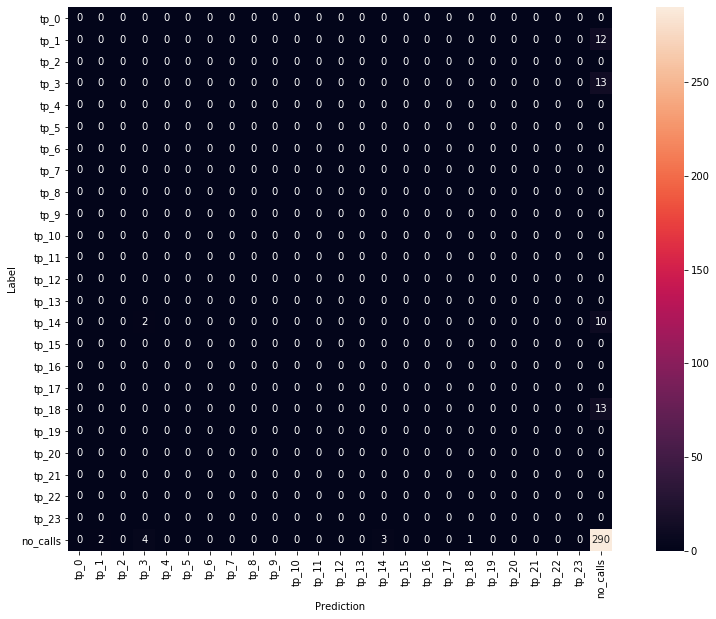

In [105]:
# pred = model_cnn_1.predict_classes(sub_X_test_np_arr, verbose=1)

# for i in zip(pred, label_number_list):

#     print(f'predicted: {i[0]:2}, actual: {i[1]:2}')

confusion_mtx = tf.math.confusion_matrix(label_number_list, pred) 
plt.figure(figsize=(16, 10))

# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)] = True
    
    
sns.heatmap(confusion_mtx, 
            xticklabels=sub_y_train.columns, yticklabels=sub_y_train.columns, 
            annot=True, 
            square=True,
            fmt='g')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [62]:
sub_X_test.iloc[0]
np.array(sub_X_test.to_list()).shape

sub_X_test_np_arr = np.array(sub_X_test.to_list())
sub_X_test_np_arr.shape

(350, 129, 376)

In [63]:
pred_test_cnn_1 = model_cnn_1.predict_classes(sub_X_test_np_arr, verbose=1)

for i in zip(pred_test_cnn_1, sub_y_test.idxmax(axis="columns")):

    print(i)

11/11 [==============================] - 0s 21ms/step
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'tp_1')
(24, 'tp_18')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(1, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'tp_3')
(24, 'no_calls')
(24, 'tp_14')
(14, 'no_calls')
(24, 'tp_14')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'tp_1')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'tp_18')
(24, 'no_calls')
(24, 'tp_3')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'tp_18')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_calls')
(24, 'no_

# CNN 2

In [64]:
model_cnn_2 = tf.keras.Sequential()

model_cnn_2.add(keras.Input(
    shape=(129,376),
    batch_size=None,
    name=None,
    dtype=None,
    sparse=False,
    tensor=None,
    ragged=False
#     **kwargs
))

print(model_cnn_2.output_shape)

# dense layers...

# this works
model_cnn_2.add(keras.layers.Dense(376, activation='relu'))

# this is experimental:
model_cnn_2.add(keras.layers.MaxPooling1D(pool_size=25, 
                                          strides=1, 
                                          padding='valid'))


model_cnn_2.add(keras.layers.Dense(64, activation='relu'))

model_cnn_2.add(keras.layers.Dropout(0.1))

model_cnn_2.add(keras.layers.Flatten())

print(model_cnn_2.output_shape)

model_cnn_2.add(keras.layers.Dense(25, activation='softmax'))


model_cnn_2.summary()

(None, 129, 376)
(None, 6720)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 129, 376)          141752    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 105, 376)          0         
_________________________________________________________________
dense_6 (Dense)              (None, 105, 64)           24128     
_________________________________________________________________
dropout (Dropout)            (None, 105, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6720)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 25)                168025    
Total params: 333,905
Trainable params: 333,905
Non-trainable params: 0
__________________

In [65]:
model_cnn_2.compile(optimizer='Adam', 
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [66]:
cnn_2_history = model_cnn_2.fit(x=sub_X_np_arr, 
                            y=sub_y_train,
                            validation_split=0.1,
                            epochs=20)

NameError: name 'sub_X_np_arr' is not defined

In [ ]:
pred_test_cnn_2 = model_cnn_1.predict_classes(sub_X_test_np_arr, verbose=1)

# pred_test_cnn_2 = np.argmax(model_cnn_1.predict_classes(sub_X_test_np_arr, verbose=1), axis=-1) 

# print (pred_test_cnn_2)
for i in zip(pred_test_cnn_2, sub_y_test.idxmax(axis="columns")):

    print(i)

In [94]:
1 / (49) ** 0.5

0.14285714285714285